<a href="https://colab.research.google.com/github/Ashur5457/Semiconductor_Wafer_Defect_Detection/blob/main/%20Data%20augmentation%20%2B%20CNN%2BRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/ashishpatel26/wm-811k-wafermap/notebook

原始資料集來自台灣大學的多媒體實驗室：
http://mirlab.org/dataSet/public/


資料集是由臺大實驗室跟台積電合作推出的論文：
Wafer Map Failure Pattern Recognition and Similarity
Ranking for Large-Scale Data Sets

In [ ]:
#載入所需的函數以及套件
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab.patches import cv2_imshow

# 資料增強使用
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import layers, models  #使用 models 取特徵模型
from sklearn.ensemble import RandomForestClassifier  #使用 RF 分類器
from sklearn.metrics import accuracy_score  #使用 RF 精確度計算

from tensorflow.keras.regularizers import l2  #Import l2 regularizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content
!ln -s "/content/drive/MyDrive/Colab Notebooks/" /googledrive
#!ln -s "/content/drive/MyDrive/_班級/交大訓練/專案_半導體瑕疵檢測/" /googledrive
!cp /googledrive/LSWMD.pkl /content

Mounted at /content/drive
/content


In [ ]:
# 讀取資料
# pkl是Python裡面的Pickle模組產生的資料封裝檔案，這個檔案只有在Python裡面搭配Pickle模組能用
# Pandas可以利用read_pickle直接把壓縮過的pkl檔案處理成data frame
data = pd.read_pickle('LSWMD.pkl')

In [ ]:
data
# waferMap晶圓表面處理過的外觀圖，dieSize有多少的壞掉的區域的數量，lotName第幾批次，waferIndex晶圓編號
# trianTestLabel原始規畫出來的訓練資料與測試資料，failureType這片晶圓是哪種錯誤型態

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]
...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]


In [ ]:
data.shape

(811457, 6)

In [ ]:
data[0:1]

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]


In [ ]:
data['waferMap'][0:1].values

array([array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)], dtype=object)

In [ ]:
#===== 前版 ======
# 舊版，因為套件無法比對空值，所以當時使用兩步過濾
# 利用DataFrame的過濾器功能進行處理
# 把Training以外的過濾掉 -> 剩下"Test"以及"其他"
#filter1 = data["trianTestLabel"] != "Training"
# 把test以外的過濾掉 -> 剩下"其他"
#filter2 = data["trianTestLabel"] != "Test"
# 進行第一次過濾
#t1 = data[filter1]
# 進行第二次過濾
#t2 = t1[filter2]
# 複製了一份DataFrame出來
#data2 = data
#a = t2.index.tolist()
# 把t2裡面的資料從data2裡面刪掉
#data2.drop(a, inplace=True)
#data2

#========新版=========
# 因為套件改版，改版後的套件變得可以直接比空值，所以只需要做一次即可
# 進行第二次過濾
# 把test以外的過濾掉 -> 剩下"其他"
filter3 = data["trianTestLabel"] != ""
data2 = data[filter3]
data2

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]
...,...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,[[Test]],[[Edge-Loc]]
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,[[Test]],[[Edge-Loc]]
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]


In [ ]:
# 計算每個dieSize的數量
dieSize_counts = data2['dieSize'].value_counts()
dieSize_counts.head(25)

,count
dieSize,
516.0,16437
533.0,14350
776.0,12400
562.0,11252
518.0,9400
741.0,8222
1109.0,7186
1414.0,6723
1376.0,6180


In [ ]:
# 因為這個資料集資料量夠多，所以我只留下dieSize是600的
# 因為如果一個晶圓的dieSize能夠死到1683個，那代表他本身的尺寸也大。
# 所以這個資料集面臨到資料尺寸不合的問題
# 之前肺部X光片之所以可以利用reSize強迫改成一樣大小是因為就算CT片的尺寸不一樣，也不會差太多
filter3 = data2["dieSize"] == 533.0
# 利用DataFrame的過濾器功能進行處理，只留下dieSize是600的，其他尺寸先不要
data3 = data2[filter3]
data3

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
150,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2,...",533.0,lot7,1.0,[[Training]],[[none]]
151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot7,2.0,[[Training]],[[none]]
152,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot7,3.0,[[Training]],[[none]]
153,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1,...",533.0,lot7,4.0,[[Training]],[[none]]
154,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,...",533.0,lot7,5.0,[[Training]],[[none]]
...,...,...,...,...,...,...
679251,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot42179,21.0,[[Test]],[[none]]
679252,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",533.0,lot42179,22.0,[[Test]],[[none]]
679253,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1,...",533.0,lot42179,23.0,[[Test]],[[none]]
679254,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1,...",533.0,lot42179,24.0,[[Test]],[[none]]


failureType
[[none]]         13489
[[Loc]]            297
[[Edge-Loc]]       289
[[Center]]          90
[[Random]]          74
[[Scratch]]         71
[[Edge-Ring]]       23
[[Near-full]]       16
[[Donut]]            1
Name: count, dtype: int64


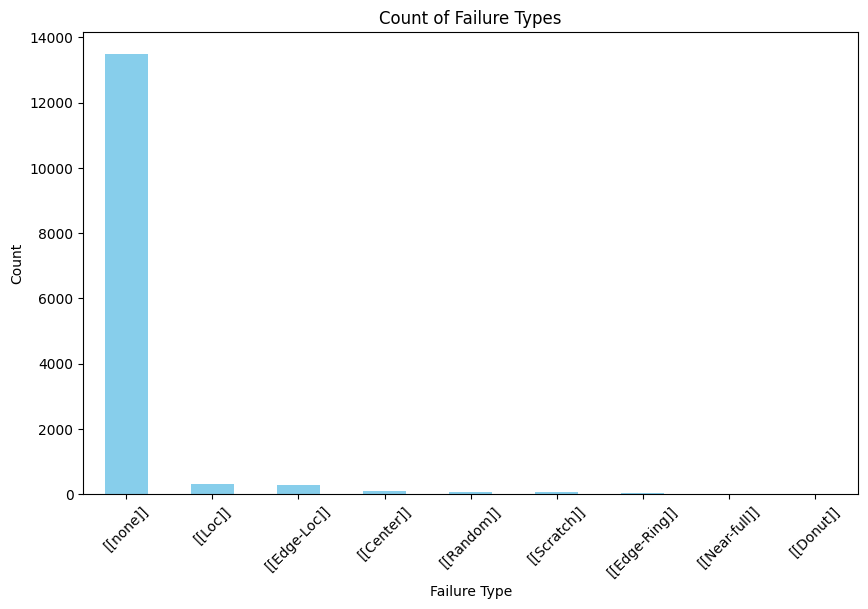

In [ ]:
#確認該 dieSize 每個 failure type 分布

# 計算每個failureType的數量
failure_counts = data3['failureType'].value_counts()
print(failure_counts)

# 繪製直方圖
plt.figure(figsize=(10, 6))
failure_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Failure Types')
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 以某一筆資料來當例子，取得尺寸是(26,30)
temp = (data3["waferMap"].values)[0]
temp.shape

(26, 26)

In [ ]:
# waferMap size
DSy = 26
DSx = 26

#===========整理原始影像與標籤===================================================
temp = (data3["waferMap"].values)
images = np.stack(temp).reshape(-1, DSy, DSx, 1)
# 訓練集跟驗證集(Label)是依照原始DataSet裡面的規定
labels = data3['failureType'].values
print(images.shape)
print(labels.shape)

#================數據增強========================================================
# 找出 "none" 類別的索引值
none_index = np.where(labels == 'none')[0]      #[0]第一個元素位置，放索引值
#print(none_index[0:20])
none_images = images[none_index]            # 根據篩選出的索引取出 "none" 的影像
none_labels = labels[none_index]            # 根據篩選出的索引取出 "none" 的標籤

Edge_Loc_index = np.where(labels == 'Edge-Loc')[0]
#print(Edge_Loc_index[0:20])
Edge_Loc_images = images[Edge_Loc_index]
Edge_Loc_labels = labels[Edge_Loc_index]

Edge_Ring_index = np.where(labels == 'Edge-Ring')[0]
#print(Edge_Ring_index[0:20])
Edge_Ring_images = images[Edge_Ring_index]
Edge_Ring_labels = labels[Edge_Ring_index]

Loc_index = np.where(labels == 'Loc')[0]
#print(Loc_index[0:20])
Loc_images = images[Loc_index]
Loc_labels = labels[Loc_index]

Scratch_index = np.where(labels == 'Scratch')[0]
#print(Scratch_index[0:20])
Scratch_images = images[Scratch_index]
Scratch_labels = labels[Scratch_index]

Center_index = np.where(labels == 'Center')[0]
#Center_index = [109,150,407,701,1498]
print('Center_index:', Center_index)
Center_images = images[Center_index]
Center_labels = labels[Center_index]

Random_index = np.where(labels == 'Random')[0]
#print(Random_index[0:20])
Random_images = images[Random_index]
Random_labels = labels[Random_index]

Near_full_index = np.where(labels == 'Near-full')[0]
#print(Near_full_index[0:20])
Near_full_images = images[Near_full_index]
Near_full_labels = labels[Near_full_index]

Donut_index = np.where(labels == 'Donut')[0]
#print(Donut_index[0:20])
Donut_images = images[Donut_index]
Donut_labels = labels[Donut_index]


# 擴增圖片方式
datagen = ImageDataGenerator(
    rotation_range=20,   # 隨機旋轉影像
    horizontal_flip=True,  # 隨機水平翻轉影像
    vertical_flip=True,  # 隨機垂直翻轉影像
#    shear_range=0.03,   # 隨機剪切範圍
#    zoom_range=0.03,    # 隨機縮放範圍
)

# 影像資料進行增強的存放容器
Edge_Loc_aug_images = []
Edge_Loc_aug_labels = []
Edge_Ring_aug_images = []
Edge_Ring_aug_labels = []
Loc_aug_images = []
Loc_aug_labels = []
Scratch_aug_images = []
Scratch_aug_labels = []
Center_aug_images = []
Center_aug_labels = []
Random_aug_images = []
Random_aug_labels = []
Near_full_aug_images = []
Near_full_aug_labels = []
Donut_aug_images = []
Donut_aug_labels = []

# 擴增各 FailureType 的 image 及對應的 label
for image, label in zip(Edge_Loc_images, Edge_Loc_labels):
    image = np.expand_dims(image, 0)              #在最前面增加一個維度以符合 datagen.flow() 的輸入要求
    for batch in datagen.flow(image, batch_size=1):      #使用 ImageDataGenerator 的 flow 擴增圖片，每次生一張
        Edge_Loc_aug_images.append(batch[0].reshape(DSy, DSx, 1)) #將擴增後的圖片 reshape 一樣的 size，放入容器內
        Edge_Loc_aug_labels.append(label)           #將對應的 label 加入列表
        if len(Edge_Loc_aug_images) >= len(none_images):  #擴增圖片數量到跟 none 相仿
          break
for image, label in zip(Edge_Ring_images, Edge_Ring_labels):
    image = np.expand_dims(image, 0)
    for batch in datagen.flow(image, batch_size=1):
        Edge_Ring_aug_images.append(batch[0].reshape(DSy, DSx, 1))
        Edge_Ring_aug_labels.append(label)
        if len(Edge_Ring_aug_images) >= len(none_images):
          break
for image, label in zip(Loc_images, Loc_labels):
    image = np.expand_dims(image, 0)
    for batch in datagen.flow(image, batch_size=1):
        Loc_aug_images.append(batch[0].reshape(DSy, DSx, 1))
        Loc_aug_labels.append(label)
        if len(Loc_aug_images) >= len(none_images):
          break
for image, label in zip(Scratch_images, Scratch_labels):
    image = np.expand_dims(image, 0)
    for batch in datagen.flow(image, batch_size=1):
        Scratch_aug_images.append(batch[0].reshape(DSy, DSx, 1))
        Scratch_aug_labels.append(label)
        if len(Scratch_aug_images) >= len(none_images):
          break
for image, label in zip(Center_images, Center_labels):
    image = np.expand_dims(image, 0)
    for batch in datagen.flow(image, batch_size=1):
        Center_aug_images.append(batch[0].reshape(DSy, DSx, 1))
        Center_aug_labels.append(label)
        if len(Center_aug_images) >= len(none_images):
          break
for image, label in zip(Random_images, Random_labels):
    image = np.expand_dims(image, 0)
    for batch in datagen.flow(image, batch_size=1):
        Random_aug_images.append(batch[0].reshape(DSy, DSx, 1))
        Random_aug_labels.append(label)
        if len(Random_aug_images) >= len(none_images):
          break
for image, label in zip(Near_full_images, Near_full_labels):
    image = np.expand_dims(image, 0)
    for batch in datagen.flow(image, batch_size=1):
        Near_full_aug_images.append(batch[0].reshape(DSy, DSx, 1))
        Near_full_aug_labels.append(label)
        if len(Near_full_aug_images) >= len(none_images):
          break
for image, label in zip(Donut_images, Donut_labels):
    image = np.expand_dims(image, 0)
    for batch in datagen.flow(image, batch_size=1):
        Donut_aug_images.append(batch[0].reshape(DSy, DSx, 1))
        Donut_aug_labels.append(label)
        if len(Donut_aug_images) >= len(none_images):
          break


# 將增強後的標籤容器轉換為一維陣列（如果它不是一維的）
Edge_Loc_aug_labels = np.array(Edge_Loc_aug_labels).flatten()
Edge_Ring_aug_labels = np.array(Edge_Ring_aug_labels).flatten()
Loc_aug_labels = np.array(Loc_aug_labels).flatten()
Scratch_aug_labels = np.array(Scratch_aug_labels).flatten()
Center_aug_labels = np.array(Center_aug_labels).flatten()
Random_aug_labels = np.array(Random_aug_labels).flatten()
Near_full_aug_labels = np.array(Near_full_aug_labels).flatten()
Donut_aug_labels = np.array(Donut_aug_labels).flatten()

# 確保 nono_label 是一維陣列
#Near_full_labels = np.array(Near_full_labels).flatten()
none_labels = np.array(none_labels).flatten()


# 將所有標籤轉換為統一的字符串格式，這樣做是為了確保標籤在後續處理時具有相同的數據類型
#Near_full_labels = [str(label) for label in Near_full_labels]
none_labels = [str(label) for label in none_labels]
Edge_Loc_aug_labels = [str(label) for label in Edge_Loc_aug_labels]
Edge_Ring_aug_labels = [str(label) for label in Edge_Ring_aug_labels]
Loc_aug_labels = [str(label) for label in Loc_aug_labels]
Scratch_aug_labels = [str(label) for label in Scratch_aug_labels]
Center_aug_labels = [str(label) for label in Center_aug_labels]
Random_aug_labels = [str(label) for label in Random_aug_labels]
Near_full_aug_labels = [str(label) for label in Near_full_aug_labels]
Donut_aug_labels = [str(label) for label in Donut_aug_labels]


# 整合增強後的影像數據 + "none" 類別的影像數據
combined_images = np.concatenate((none_images, Edge_Loc_aug_images, Edge_Ring_aug_images, Loc_aug_images, Scratch_aug_images,
                  Center_aug_images, Random_aug_images, Near_full_aug_images, Donut_aug_images))
combined_labels = np.concatenate((none_labels, Edge_Loc_aug_labels, Edge_Ring_aug_labels, Loc_aug_labels, Scratch_aug_labels,
                  Center_aug_labels, Random_aug_labels, Near_full_aug_labels, Donut_aug_labels))

# 隨機打亂資料
combined_images, combined_labels = shuffle(combined_images, combined_labels, random_state=42)


print(f"none 資料數量: {len(none_images)}")
print(f"Edge_Loc 數量: {len(Edge_Loc_aug_images)}")
print(f"Edge_Ring 數量: {len(Edge_Ring_aug_images)}")
print(f"Loc_full 數量: {len(Loc_aug_images)}")
print(f"Scratch 數量: {len(Scratch_aug_images)}")
print(f"Center 數量: {len(Center_aug_images)}")
print(f"Random 數量: {len(Random_aug_images)}")
print(f"Near_full 數量: {len(Near_full_aug_images)}")
print(f"Donut 數量: {len(Donut_aug_images)}")
print(combined_images.shape)
print(combined_labels.shape)
#print(none_labels[0], type(none_labels))
#print(Edge_Loc_labels[0], type(Edge_Loc_labels))

(14350, 26, 26, 1)
(14350,)
Center_index: [  397   499   637  2103  3224  3751  4183  4601  5155  5160  5784  6174
  6268  6269  6296  6297  6324  6325  6326  6327  6330  6331  6332  6333
  6334  6335  6336  6352  6614  6615  6723  7022  7128  7208  7285  7533
  7539  7573  7671  7788  7795  7802  7949  8121  8189  8260  8352  8652
  8786  8835  9108  9213  9611 10043 10162 10861 11012 11153 11353 11421
 11477 11520 11578 11583 11651 11674 12020 12172 12212 12268 12281 12437
 12446 12596 12879 12915 12993 13142 13588 13591 13594 13597 13598 13789
 13808 13888 13980 14043 14220 14259]
none 資料數量: 13489
Edge_Loc 數量: 13777
Edge_Ring 數量: 13511
Loc_full 數量: 13785
Scratch 數量: 13559
Center 數量: 13578
Random 數量: 13562
Near_full 數量: 13504
Donut 數量: 13489
(122254, 26, 26, 1)
(122254,)


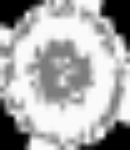

Donut


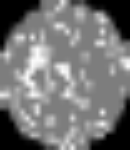

Loc


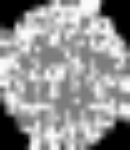

Random


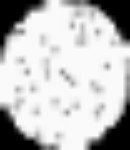

Near-full


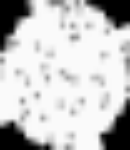

Near-full


In [ ]:
# 展示部分資料
for i in range(0,5):
  img = combined_images[i] * 125
  img = cv2.resize(img,(130,150))
  cv2_imshow(img)
  print(combined_labels[i])

資料集中的可能錯誤樣態列表

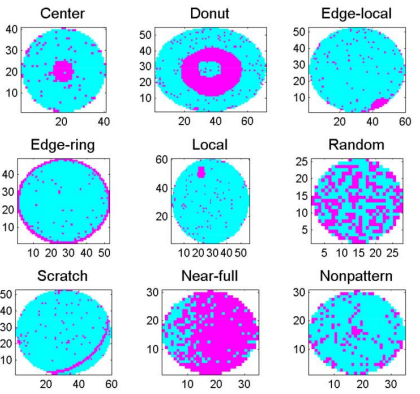

In [ ]:
# 模型不能處理字串，只能處理數字
# 將標籤轉換為數字，這邊使用的是 one-hot
label_encoder = LabelEncoder()
combined_labels = label_encoder.fit_transform(combined_labels)
combined_labels = to_categorical(combined_labels)

In [ ]:
combined_labels[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# 切分訓練與驗證資料集
train_images, val_images, train_labels, val_labels = train_test_split(combined_images, combined_labels, test_size=0.2, random_state=42)


In [ ]:
# CNN+RF 模型

def create_cnn_model(input_shape=(DSy, DSx, 1)):
   model = Sequential()
   model.add(Conv2D(32, kernel_size=(3,3), padding='same', input_shape=(DSy,DSx,1), activation='relu'))
   model.add(MaxPooling2D(pool_size=(2,2)))
   model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
   model.add(MaxPooling2D(pool_size=(2,2)))
#   model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))  #增加一層CNN無效
#   model.add(MaxPooling2D(pool_size=(2,2)))
#   model.add(Dropout(0.5))
   model.add(Flatten())
   model.add(Dense(128, activation='relu'))    #加大全連接神經元會變好一點
   return model

# 引入CNN model
cnn_model = create_cnn_model(input_shape=(DSy, DSx, 1))
feature_extractor = models.Model(inputs=cnn_model.inputs, outputs=cnn_model.layers[-1].output)

# 取訓練集特徵
features = feature_extractor.predict(train_images)

# 訓練隨機森林
rf = RandomForestClassifier(n_estimators=100, random_state=42)     #增加決策數無效
rf.fit(features, train_labels)  # 使用CNN提取的特徵和對應的標籤進行訓練

# 取驗證集特徵
test_features = feature_extractor.predict(val_images)
val_pred = rf.predict(test_features)

# 驗證集效能評估 and 混淆矩陣_1
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
y_true = np.argmax(val_labels, axis=1)
y_pred = np.argmax(val_pred, axis=1)

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3057/3057 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
765/765 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 99.37%


Accuracy: 99.37%
              precision    recall  f1-score   support

           0    0.99384   0.99097   0.99241      2769
           1    1.00000   1.00000   1.00000      2712
           2    1.00000   0.98044   0.99012      2709
           3    1.00000   0.99924   0.99962      2649
           4    1.00000   0.98129   0.99056      2780
           5    1.00000   1.00000   1.00000      2672
           6    1.00000   0.99776   0.99888      2675
           7    1.00000   0.99405   0.99701      2856
           8    0.95013   1.00000   0.97443      2629

    accuracy                        0.99366     24451
   macro avg    0.99377   0.99375   0.99367     24451
weighted avg    0.99394   0.99366   0.99371     24451



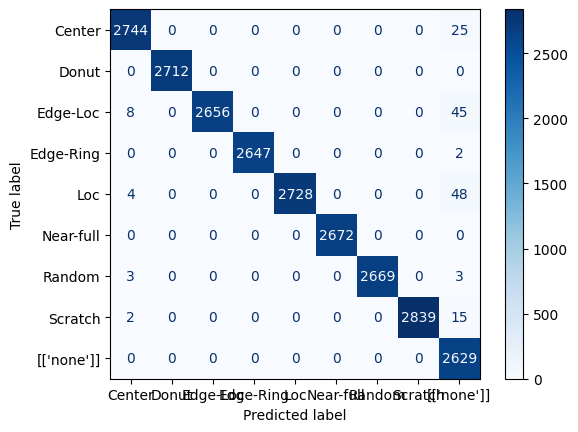

In [ ]:
# 驗證集效能評估 and 混淆矩陣_2
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, digits=5)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(report)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:

#print('預測類型', val_pred[0])
#print('實際類型', val_labels[0])
print('驗證集 預測shape', val_pred.shape)
print('驗證集 實際shape', val_labels.shape)

# 預測結果跟實際結果比對
print('以下為預測錯誤圖片')
for i, VAL_pred in enumerate(val_pred):
#   print(i, label_encoder.classes_[np.argmax(val_pred[i])], label_encoder.classes_[np.argmax(val_labels[i])])
   if (label_encoder.classes_[np.argmax(val_pred[i])] != label_encoder.classes_[np.argmax(val_labels[i])]):
     print(i, label_encoder.classes_[np.argmax(val_pred[i])], label_encoder.classes_[np.argmax(val_labels[i])])

驗證集 預測shape (24451, 9)
驗證集 實際shape (24451, 9)
以下為預測錯誤圖片
495 [['none']] Edge-Loc
868 [['none']] Loc
1217 [['none']] Scratch
1390 [['none']] Edge-Loc
1501 [['none']] Random
1850 [['none']] Edge-Loc
1861 [['none']] Loc
2016 [['none']] Edge-Loc
2027 [['none']] Edge-Loc
2317 Center Edge-Loc
2420 [['none']] Loc
2585 Center Edge-Loc
2617 [['none']] Loc
2805 [['none']] Center
3124 [['none']] Edge-Loc
3376 [['none']] Edge-Loc
3397 [['none']] Loc
3573 [['none']] Edge-Loc
3651 [['none']] Center
3785 [['none']] Edge-Loc
4024 Center Random
4132 [['none']] Scratch
4226 [['none']] Loc
4234 [['none']] Loc
4401 [['none']] Center
4432 [['none']] Center
4626 [['none']] Scratch
4740 [['none']] Edge-Loc
4846 Center Edge-Loc
4906 [['none']] Random
5036 [['none']] Center
5101 [['none']] Edge-Loc
5231 [['none']] Edge-Loc
5422 [['none']] Edge-Loc
5500 [['none']] Scratch
5505 [['none']] Loc
5550 [['none']] Center
5757 [['none']] Loc
5826 [['none']] Edge-Loc
5932 [['none']] Center
6065 Center Random
6120 Center 

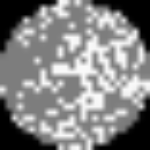

Predicted: [['none']]
Actual: Random
[0. 0. 0. 0. 0. 0. 0. 0. 1.]
8


In [ ]:
# 預測一筆資料
ppp= 7152
test_image = val_images[ppp]
test_pred = val_pred[ppp]
test_label = val_labels[ppp]

# 顯示要預測的資料原始圖檔
img = test_image * 125
img = cv2.resize(img,(150,150))
cv2_imshow(img)

print('Predicted:', label_encoder.classes_[np.argmax(test_pred)])
print('Actual:', label_encoder.classes_[np.argmax(test_label)])
print(val_pred[ppp])
print(y_pred[ppp])

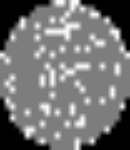

original_Center 98


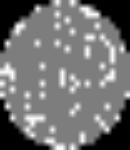

original_Center 109


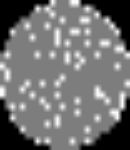

original_Center 150


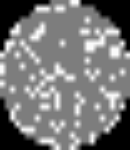

original_Center 188


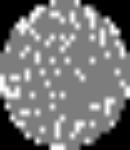

original_Center 407


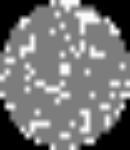

original_Center 701


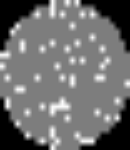

original_Center 1498


In [ ]:
#Center_index: [  98  109  150  188  407  701 1498]
original_image = images[98]


# 原始Center圖檔
img = images[98] * 125
img = cv2.resize(img,(130,150))
cv2_imshow(img)
print('original_Center 98')

img = images[109] * 125
img = cv2.resize(img,(130,150))
cv2_imshow(img)
print('original_Center 109')

img = images[150] * 125
img = cv2.resize(img,(130,150))
cv2_imshow(img)
print('original_Center 150')

img = images[188] * 125
img = cv2.resize(img,(130,150))
cv2_imshow(img)
print('original_Center 188')


img = images[407] * 125
img = cv2.resize(img,(130,150))
cv2_imshow(img)
print('original_Center 407')


img = images[701] * 125
img = cv2.resize(img,(130,150))
cv2_imshow(img)
print('original_Center 701')


img = images[1498] * 125
img = cv2.resize(img,(130,150))
cv2_imshow(img)
print('original_Center 1498')